In [20]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.interpolate import interp1d

from cosmoprimo import fiducial

from densitysplit.corr_func_utils import get_poles
from densitysplit.density_split_model import *

# to automatically reload imported modules when executing cell
%load_ext autoreload
%autoreload 2

setup_logging()

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

plots_dir = '/feynman/home/dphp/mp270220/plots/densitysplit'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Global parameters

In [2]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8
ells = [0]
nells = len(ells)

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## 2PCF model

In [3]:
basemodel = BaseTwoPointCorrelationFunctionModel(redshift=z, cosmology=cosmology, damping=True, b1=bias, boxsize=1000, nmesh=512)

[000000.22]  06-06 17:45  BaseTwoPointCorrelationFunctionModel INFO     Initializing BaseTwoPointCorrelationFunctionModel
[000000.22]  06-06 17:45  BaseTwoPointCorrelationFunctionModel INFO     Initializing theoretical 1D power spectrum
[000000.66]  06-06 17:45  BaseTwoPointCorrelationFunctionModel INFO     Applying damping from 80% of Nyquist frequency
[000000.66]  06-06 17:45  BaseTwoPointCorrelationFunctionModel INFO     Initializing ParticleMesh with boxisze 1000, nmesh 512
[000000.66]  06-06 17:45  BaseTwoPointCorrelationFunctionModel INFO     Painting 1D power spectrum on 3D mesh


/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:523: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


[000131.71]  06-06 17:47  BaseTwoPointCorrelationFunctionModel INFO     3D power spectrum calculated in 131.05 seconds.


## $\xi(s)$

In [4]:
xi_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

xi_fn = '10gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar0.010_2PCF.npy'.format(z, bias, boxsize, nmesh)
xi = np.load(os.path.join(xi_dir, xi_fn), allow_pickle=True)
xi_ells, cov = get_poles(xi, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, _ = xi[0].get_corr(return_sep=True)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


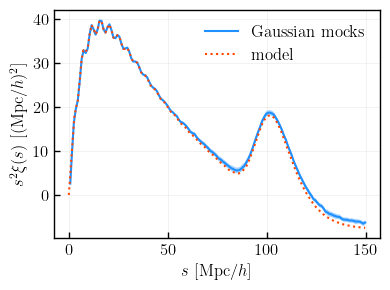

In [5]:
plt.rcParams["figure.figsize"] = (4, 3)

for ill, ell in enumerate(ells):
    y = s**2 * xi_ells[ill]
    error = s**2 * std[ill]

    plt.plot(s, y, label='Gaussian mocks')
    plt.fill_between(s, y-error, y+error, alpha=0.4)
    plt.plot(basemodel.sep, basemodel.sep**2 * basemodel.xi, label=r'model', ls=':')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig(os.path.join(plots_dir, 'gaussian_mocks_2PCF.pdf'), dpi=500)
plt.show()

## $\xi_{R}(s)$

In [6]:
smoothedmodel = SmoothedTwoPointCorrelationFunctionModel(basemodel, smoothing_scale=cellsize)

[000144.44]  06-06 17:47  BaseTwoPointCorrelationFunctionModel INFO     Initializing SmoothedTwoPointCorrelationFunctionModel
[000144.44]  06-06 17:47  BaseTwoPointCorrelationFunctionModel INFO     Setting smoothing scale to 10
[000144.44]  06-06 17:47  BaseTwoPointCorrelationFunctionModel INFO     Setting 3D smoothign kernel of order 6


/feynman/home/dphp/mp270220/densitysplit/densitysplit/density_split_model.py:136: RuntimeWarning: invalid value encountered in sqrt
  self.smoothed_sigma = np.sqrt(np.real(xiR))


[000177.74]  06-06 17:48  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to None


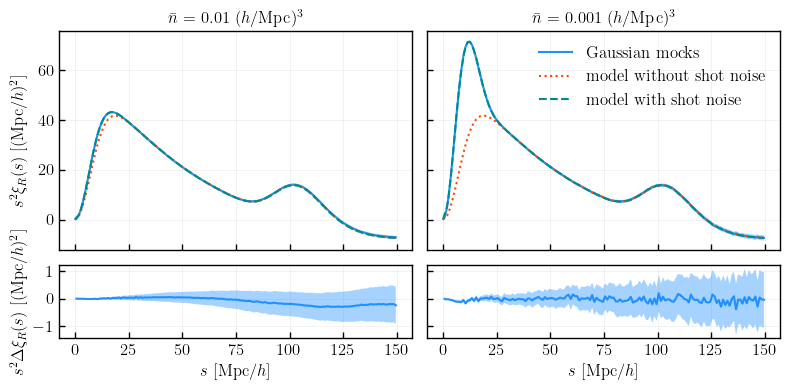

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})

nbar = (0.01, 0.001)

for i, nb in enumerate(nbar):
    xiR = list()
    for batch_index in range(10):
        xi_fn = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_xi_R.npy'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler)
        batch_results = np.load(os.path.join(xi_dir, xi_fn), allow_pickle=True)
        for batch in batch_results:
            xiR.append(batch)

    xiR_ells, cov = get_poles(xiR, ells)
    std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
    s, _, _ = xiR[0].get_corr(return_sep=True)
    
    ## Model
    model_xiR = smoothedmodel.set_smoothed_xi(nbar=0)
    model_xiR_shotnoise = smoothedmodel.set_smoothed_xi(nbar=nb)

    for ill, ell in enumerate(ells):
        y = s**2 * xiR_ells[ill]
        error = s**2 * std[ill]
    
        axes[0][i].plot(s, y, label='Gaussian mocks')
        axes[0][i].fill_between(s, y-error, y+error, alpha=0.4)
        axes[0][i].plot(smoothedmodel.sep, smoothedmodel.sep**2 * model_xiR, label=r'model without shot noise', ls=':')
        axes[0][i].plot(smoothedmodel.sep, smoothedmodel.sep**2 * model_xiR_shotnoise, label=r'model with shot noise', ls='--')
        axes[0][i].set_title(r'$\bar{{n}}$ = {:.1g} $(h/\mathrm{{Mpc}})^3$'.format(nb))
        
        model_interp = interp1d(smoothedmodel.sep.transpose()[0], model_xiR_shotnoise.transpose()[0])
        y_err = s**2 * (model_interp(s) - xiR_ells[ill])
        axes[1][i].plot(s, y_err, label='Mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
        axes[1][i].fill_between(s, y_err-error, y_err+error, alpha=0.4)
        axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
fig.align_ylabels()
axes[0][1].legend()
plt.savefig(os.path.join(plots_dir, 'gaussian_mocks_xiR.pdf'), dpi=500)
plt.show()

## $\delta_R$

In [8]:
smootheddensitymodel = SmoothedGaussianDensityModel(smoothedmodel)

[000311.00]  06-06 17:50  BaseTwoPointCorrelationFunctionModel INFO     Initializing SmoothedGaussianDensityModel


[000312.67]  06-06 17:50  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0.01
[000350.00]  06-06 17:51  BaseTwoPointCorrelationFunctionModel INFO     Computing moments of the smoothed density contrast.
[000359.73]  06-06 17:51  BaseTwoPointCorrelationFunctionModel INFO     1st order moment: 0.9999999999999984.
[000361.11]  06-06 17:51  BaseTwoPointCorrelationFunctionModel INFO     2nd order moment: [1.29392787].
[000369.36]  06-06 17:51  BaseTwoPointCorrelationFunctionModel INFO     3rd order moment: [1.89442212].
[000411.05]  06-06 17:52  BaseTwoPointCorrelationFunctionModel INFO     4th order moment: [3.08294625].
[000411.05]  06-06 17:52  BaseTwoPointCorrelationFunctionModel INFO     Moments of the smoothed density contrast computed in elapsed time 61.044246196746826 seconds.
[000417.78]  06-06 17:52  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0.001
[000451.89]  06-06 17:52  BaseTwoPointCorrelationFunctionModel INFO     Computing moments of the smoo

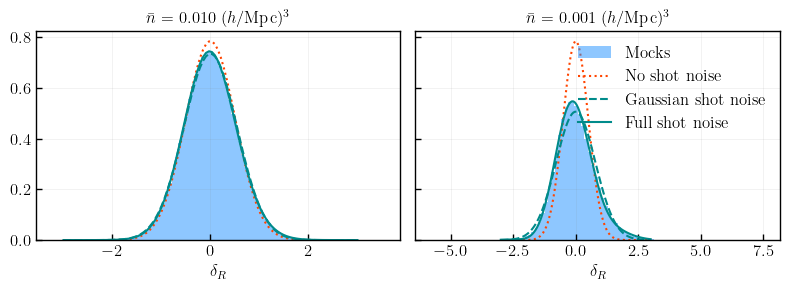

In [9]:
mocks_dir = '/feynman/work/dphp/mp270220/outputs/mocks/gaussian/'
delta_fn = '{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{{:.3f}}_cellsize{:d}_resampler{}_delta_R.npy'.format(10, z, bias, boxsize, nmesh, cellsize, resampler)

delta = np.linspace(-3, 3, 100)

fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8, 3))

for i, nb in enumerate(nbar):
    ## Mocks
    densities = np.load(os.path.join(mocks_dir, delta_fn.format(nb)))
    
    ## Model
    model_density = scipy.stats.norm.pdf(delta, 0, smootheddensitymodel.double_smoothed_sigma)
    model_density_gaussianshotnoise = smootheddensitymodel.density(delta, p=2, nbar=nb)
    model_density_fullshotnoise = smootheddensitymodel.density(delta, p=4, nbar=nb)

    axes[i].hist(np.ravel(densities), bins=100, density=True, alpha=0.5, label='Mocks')
    axes[i].plot(delta, model_density, label='No shot noise', ls=':', color='orangered')
    axes[i].plot(delta, model_density_gaussianshotnoise, label='Gaussian shot noise', ls='--', color='darkcyan')
    axes[i].plot(delta, model_density_fullshotnoise, label='Full shot noise', ls='-', color='darkcyan')
    axes[i].set_xlabel(r'$\delta_R$')
    axes[i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
    
axes[1].legend()
plt.savefig(os.path.join(plots_dir, 'gaussian_mocks_deltaR.pdf'), dpi=500)
plt.show()

## $\xi_R^{DS}$ (randoms - tracers)

In [15]:
nsplits = 3
randoms_size = 4
density_bins = np.array([-np.inf, -0.21875857,  0.21875857, np.inf])

In [16]:
smootheddensitysplitsmodel = GaussianDensitySplitsModel(smootheddensitymodel, nsplits=nsplits, randoms_size=randoms_size, density_bins=density_bins)

[001021.66]  06-06 18:02  BaseTwoPointCorrelationFunctionModel INFO     Initializing GaussianDensitySplitsModel with 3 density splits


[000505.40]  06-06 18:14  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0


/feynman/home/dphp/mp270220/densitysplit/densitysplit/density_split_model.py:136: RuntimeWarning: invalid value encountered in sqrt
  self.smoothed_sigma = np.sqrt(np.real(xiR))


[000523.00]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     nbar is 0, density is Gaussian.
[000523.00]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     Computing cross-correlation of density-split randoms and all tracers.
[000523.45]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     Setting nbar to 0.01
[000557.82]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     Computing moments of the smoothed density contrast.
[000566.26]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     1st order moment: -1.5543122344752192e-15.
[000567.60]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     2nd order moment: 1.293927867163304.
[000575.82]  06-06 18:15  BaseTwoPointCorrelationFunctionModel INFO     3rd order moment: 1.8944221195798694.
[000618.31]  06-06 18:16  BaseTwoPointCorrelationFunctionModel INFO     4th order moment: 3.0829462543641357.
[000618.31]  06-06 18:16  BaseTwoPointCorrelationFunctionModel INFO     Moments of the smooth

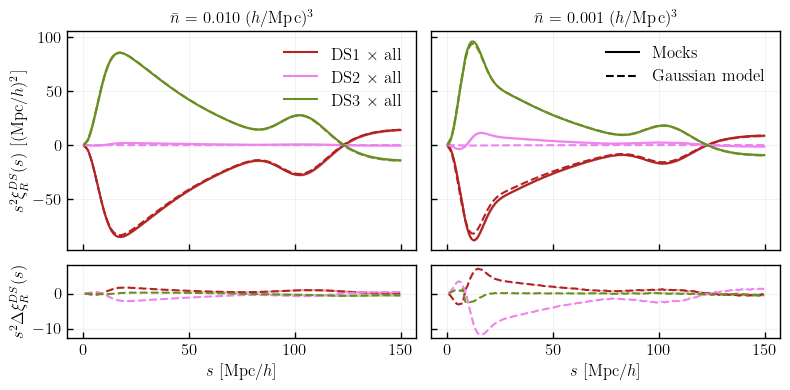

In [23]:
plt.rcParams["figure.figsize"] = (8, 4)
fig, axes = plt.subplots(2, 2, sharex=True, sharey='row', gridspec_kw={'height_ratios': [3, 1]})
colors = ['firebrick', 'violet', 'olivedrab']

model_ccf = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=0, p=0)

for i, nb in enumerate(nbar):
    xiR = list()
    for batch_index in range(10):
        xi_fn = '10gaussianMocks_batch{:d}_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nb, cellsize, resampler, nsplits, randoms_size)
        batch_results = np.load(xi_dir+xi_fn+'_RH_CCF.npy', allow_pickle=True)
        for batch in batch_results:
            xiR.append(batch)

    ## Mocks
    mocks_split_xi_rh, cov_rh = get_split_poles(xiR, ells=ells, nsplits=nsplits)
    std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(100)
    s, _, _ = xiR[0][0].get_corr(return_sep=True)
    
    ## Model
    model_ccf_gaussian_shotnoise = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=nb, p=2)
    model_ccf_full_shotnoise = smootheddensitysplitsmodel.ccf_randoms_tracers(nbar=nb, p=4)
    
    for ill, ell in enumerate(ells):
        for ds in range(nsplits):
            y = s**2 * mocks_split_xi_rh[ds][ill]
            error = s**2 * std_rh[ds][ill]

            axes[0][i].plot(s, y, color=colors[ds])
            axes[0][i].fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
            #axes[0][i].plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_ccf[ds], ls=':', color=colors[ds])
            #axes[0][i].plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_ccf_gaussian_shotnoise[ds], ls='-.', color=colors[ds])
            axes[0][i].plot(smootheddensitysplitsmodel.sep, smootheddensitysplitsmodel.sep**2 * model_ccf_full_shotnoise[ds], ls='--', color=colors[ds])
            axes[0][i].set_title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))
            
            model_interp_gaussian_shotnoise = scipy.interpolate.interp1d(smootheddensitysplitsmodel.sep.transpose()[0], model_ccf_gaussian_shotnoise[ds].transpose()[0])
            y_err_gaussian_shotnoise = s**2 * (model_interp_gaussian_shotnoise(s) - mocks_split_xi_rh[ds][ill])
            model_interp_full_shotnoise = scipy.interpolate.interp1d(smootheddensitysplitsmodel.sep.transpose()[0], model_ccf_full_shotnoise[ds].transpose()[0])
            y_err_full_shotnoise = s**2 * (model_interp_full_shotnoise(s) - mocks_split_xi_rh[ds][ill])
            #axes[1][i].plot(s, y_err_gaussian_shotnoise, label='Mocks', ls='-.', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            #axes[1][i].fill_between(s, y_err_gaussian_shotnoise-error, y_err_gaussianshot_noise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].plot(s, y_err_full_shotnoise, label='Gaussian mocks', ls='--', color=colors[ds]) # ($\bar{{n}}$ = {:.1e})'.format(nbar))
            axes[1][i].fill_between(s, y_err_full_shotnoise-error, y_err_full_shotnoise+error, alpha=0.4, facecolor=colors[ds])
            axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

for ds in range(nsplits):
    axes[0][0].plot([], [], label=r'DS{} $\times$ all'.format(ds+1), color=colors[ds])
axes[0][1].plot([], [], ls='-', color='black', label='Mocks')
#axes[0][1].plot([], [], ls=':', color='black', label='No shot noise')
#axes[0][1].plot([], [], ls='-.', color='black', label='Gaussian shot noise')
axes[0][1].plot([], [], ls='--', color='black', label='Gaussian model')
axes[0][0].legend()
axes[0][1].legend()

axes[0][0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_{R}^{DS}(s)$')
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'gaussianModelvsMocks_densitysplits.pdf'), dpi=500)
plt.show()